In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# /content/drive/MyDrive/MIT-IB-20250507T110438Z-1-001/MIT-IB

In [ ]:
!pip install opencv-python-headless numpy scikit-learn matplotlib tensorflow


In [2]:
# Step 1: Data Preparation
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

image_size = (128, 128)

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
    return images

female_images = load_images_from_folder("/content/drive/MyDrive/MIT-IB-20250507T110438Z-1-001/MIT-IB/female")
male_images = load_images_from_folder("/content/drive/MyDrive/MIT-IB-20250507T110438Z-1-001/MIT-IB/male1")



## Data Augmentation

In [3]:
# Augment female images to reach 600
aug_gen = ImageDataGenerator(rotation_range=15, horizontal_flip=True)
augmented_females = []
while len(female_images) + len(augmented_females) < 600:
    for img in female_images:
        if len(female_images) + len(augmented_females) >= 600:
            break
        img_exp = np.expand_dims(img, 0)
        aug_img = next(aug_gen.flow(img_exp, batch_size=1))[0].astype(np.uint8)
        augmented_females.append(aug_img)

X_female = female_images + augmented_females
X_male = male_images[:600]

y_female = [0] * len(X_female)
y_male = [1] * len(X_male)

X_balanced = np.array(X_female + X_male)
y_balanced = np.array(y_female + y_male)

X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)
X_balanced = X_balanced / 255.0



In [ ]:
!pip install numpy==1.24.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 110.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is

## feature engineering

In [4]:
# Step 2: Feature Engineering
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model

# HOG + LBP features
hog_features = []
lbp_features = []

for img in X_balanced:
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)
    hog_features.append(hog_feat)
    lbp_features.append(lbp_hist)

hog_features = np.array(hog_features)
lbp_features = np.array(lbp_features)

# VGG19 Deep Features
vgg = VGG19(weights='imagenet', include_top=True)
model_fc7 = Model(inputs=vgg.input, outputs=vgg.get_layer('fc2').output)

X_resized = cv2.resize(X_balanced[0], (224, 224))
X_vgg_ready = np.array([cv2.resize((img * 255).astype('uint8'), (224, 224)) for img in X_balanced])
X_vgg_ready = preprocess_input(X_vgg_ready)
vgg_features = model_fc7.predict(X_vgg_ready, verbose=1)



574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 354ms/step


## Dimensionality Reduction using PCA

In [5]:
# Step 3: Feature Fusion and Dimensionality Reduction
fused_features = np.hstack([hog_features, lbp_features, vgg_features])

pca = PCA(n_components=300)
fused_reduced = pca.fit_transform(fused_features)



## Classification (Linear SVM + Evaluation)

In [6]:
# Step 4: Classification
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = SVC(kernel='linear', C=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf, fused_reduced, y_balanced, cv=kfold)
print("Accuracy (10-fold):", np.mean(scores))



Accuracy (10-fold): 0.7433333333333334


## Train & Evaluate with 10-Fold Cross-Validation

              precision    recall  f1-score   support

      Female       0.70      0.77      0.73       114
        Male       0.77      0.70      0.73       126

    accuracy                           0.73       240
   macro avg       0.74      0.74      0.73       240
weighted avg       0.74      0.73      0.73       240



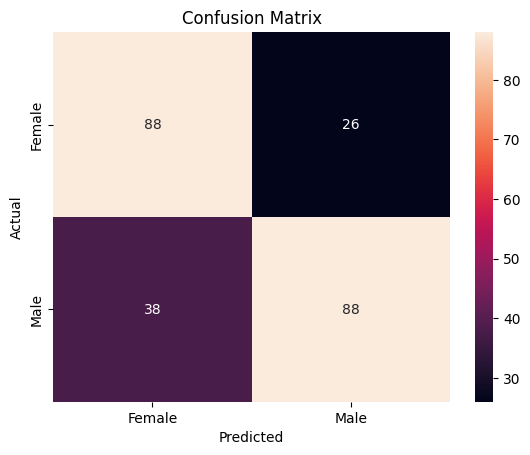

In [7]:
# Train-Test Split for final metrics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fused_reduced, y_balanced, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Female', 'Male']))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



## save model

In [8]:
# Save the model
import joblib
joblib.dump(clf, "svm_gender_model.pkl")



['svm_gender_model.pkl']

## load model

In [17]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array



# Updated version of predict_image to support PIL image input
def predict_image_pil(pil_img):
    img = img_to_array(pil_img) / 255.0
    img_resized = cv2.resize(img, image_size)
    gray = cv2.cvtColor((img_resized * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)

    hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)

    img_vgg = cv2.resize((img * 255).astype('uint8'), (224, 224))
    img_vgg = preprocess_input(np.expand_dims(img_vgg, axis=0))
    vgg_feat = model_fc7.predict(img_vgg)

    final_feat = np.hstack([hog_feat, lbp_hist, vgg_feat.squeeze()])
    final_feat = pca.transform([final_feat])
    pred = model_loaded.predict(final_feat)
    return "Female" if pred[0] == 0 else "Male"




In [21]:
# Example:

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Run prediction
img = load_img(img_path, target_size=(224, 224))
print("Prediction:", predict_image_pil(img))

Saving images (1).jpg to images (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Male
